# .pcd to ndarray
Install pypcd using below command on cmd:  
`pip install --user git+https://github.com/DanielPollithy/pypcd.git`  
It can run on python3 not just python2,and it's working fine on python3.6 which I'm using on my laptop.

In [1]:
from pypcd import pypcd
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import time
import math
%matplotlib inline

In [2]:
pc=pypcd.PointCloud.from_path('pcd/Fig4.pcd')

In [3]:
pc.get_metadata()

{'version': '.7',
 'fields': ['x', 'y', 'z', 'rgb'],
 'size': [4, 4, 4, 4],
 'type': ['F', 'F', 'F', 'F'],
 'count': [1, 1, 1, 1],
 'width': 757,
 'height': 605,
 'viewpoint': [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 'points': 457985,
 'data': 'ascii'}

In [4]:
rgb_column=pypcd.decode_rgb_from_pcl(pc.pc_data['rgb'])
rgb_column.shape

(457985, 3)

In [5]:
rgb_column[:10]

array([[ 94,  98, 109],
       [ 95,  99, 110],
       [ 96, 100, 111],
       [ 96, 100, 111],
       [ 95,  99, 110],
       [ 94,  98, 109],
       [ 94,  98, 109],
       [ 94,  98, 109],
       [ 98, 102, 113],
       [ 98, 102, 113]], dtype=uint8)

In [6]:
image=rgb_column.reshape(pc.height,pc.width,3).astype(float)
image[:10,:10,:]

array([[[ 94.,  98., 109.],
        [ 95.,  99., 110.],
        [ 96., 100., 111.],
        [ 96., 100., 111.],
        [ 95.,  99., 110.],
        [ 94.,  98., 109.],
        [ 94.,  98., 109.],
        [ 94.,  98., 109.],
        [ 98., 102., 113.],
        [ 98., 102., 113.]],

       [[ 93.,  97., 108.],
        [ 94.,  98., 109.],
        [ 96., 100., 111.],
        [ 96., 100., 111.],
        [ 95.,  99., 110.],
        [ 95.,  99., 110.],
        [ 95.,  99., 110.],
        [ 96., 100., 111.],
        [ 97., 101., 112.],
        [ 98., 102., 113.]],

       [[ 93.,  97., 108.],
        [ 94.,  98., 109.],
        [ 96., 100., 111.],
        [ 96., 100., 111.],
        [ 96., 100., 111.],
        [ 95.,  99., 110.],
        [ 96., 100., 111.],
        [ 97., 101., 112.],
        [ 96., 100., 111.],
        [ 97., 101., 112.]],

       [[ 94.,  98., 109.],
        [ 95.,  99., 110.],
        [ 96., 100., 111.],
        [ 96., 100., 111.],
        [ 95.,  99., 110.],
        [ 95.,

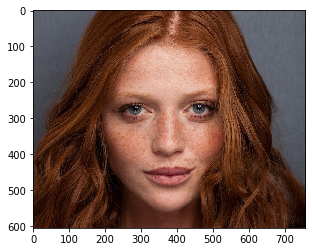

In [7]:
plt.imshow(image.astype(int))

#  Define Convolution method

In [8]:
def cross_correlation(m1,m2):
        return np.sum(m1*m2)

In [9]:
def conv2D(image,kernel):
    H,W,C=image.shape
    fh,fw=kernel.shape
    image_pad=np.pad(image,((fh//2,fh//2),((fw//2,fw//2)),(0,0)),'symmetric')
    #print('image shape:',image.shape,' image_padding shape:',image_pad.shape)
    res=np.zeros(image.shape,float)
    for i in range(H):
        for j in range(W):
            for c in range(C):
                res[i,j,c]=cross_correlation(image_pad[i:i+fh,j:j+fw,c],kernel)
    return res

# Mean Filter
1. mean filter(seperable) 
2. fast mean filter or Integral image
3. opencv fuction
4. compare three's computational time

In [10]:
#7*7 or 11*11 filter size
size=11

## 1. mean filter(seperable)

In [11]:
kernel=(1/size)*np.ones((1,size),float)
tstart=time.time() #time start
blur_x=conv2D(image,kernel)
blur_xy=conv2D(blur_x,kernel.T)
tend=time.time() #time end
time_mean=tend-tstart

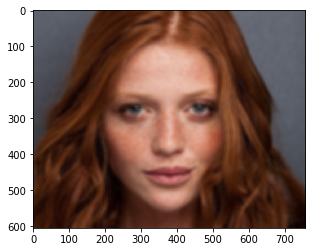

In [12]:
plt.imshow(blur_xy.astype(int))

## 2. fast mean filter or Integral image

In [13]:
def integral(image):
    H,W,C=image.shape
    res=np.zeros(image.shape,float)
    #init
    res[:,0,:]=image[:,0,:]
    res[0,:,:]=image[0,:,:]
    #dp for prefix
    for i in range(1,H):
        for j in range(1,W):
            for c in range(C):
                res[i,j,c]=image[i,j,c]+res[i-1,j,c]+res[i,j-1,c]-res[i-1,j-1,c]
    return res

In [14]:
tstart=time.time() #time start
#上下左右zero padding
image_pad=np.pad(image,((size//2,size//2),(size//2,size//2),(0,0)),'constant')
integral_pad=integral(image_pad)
#左上zero padding
integral_pad=np.pad(integral_pad,((1,0),(1,0),(0,0)),'constant')

H,W,C=image.shape
blur=np.zeros(image.shape,float)
for i in range(H):
    for j in range(W):
        for c in range(C):
            blur[i,j,c]=(1/(size*size))*(integral_pad[i+size,j+size,c]-integral_pad[i+size,j,c]
                                         -integral_pad[i,j+size,c]+integral_pad[i,j,c])
tend=time.time() #time end
time_fastmean=tend-tstart

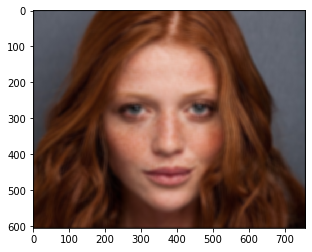

In [15]:
plt.imshow(blur.astype(int))

## 3. opencv function

In [16]:
tstart=time.time() #time start
blur=cv2.blur(image,(size,size))
tend=time.time() #time end
time_cvmean=tend-tstart

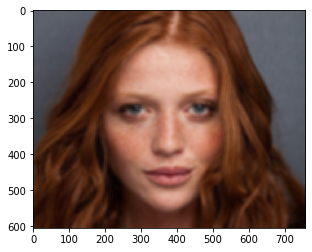

In [17]:
plt.imshow(blur.astype(int))

## 4. time consuming
'fast mean filter' is about 3~4 times faster than 'mean filter' whenever filter size is 7 or 11.  
By testing,7x7 filter takes almost the same time as 11x11 filter.  
opencv library function is hundred times faster than mine...  

In [18]:
print('1.mean filter: {:.2f} sec'.format(time_mean))
print('2.fast mean filter: {:.2f} sec'.format(time_fastmean))
print('3.opencv mean filter: {:.2f} sec'.format(time_cvmean))

1.mean filter: 21.29 sec
2.fast mean filter: 4.54 sec
3.opencv mean filter: 0.01 sec


# Binomial Filter
We can use binomial filter to approach gaussian filter.
1. implement without seperable
2. implement with seperable
3. opencv function
4. compare two's computational time

In [19]:
#7*7 or 11*11 filter size
size=7

## 1. Binomial without seperable

In [20]:
#size is odd,n is even.
n=size-1
kernel=(1/(2**n))*np.asarray([ math.factorial(n)//math.factorial(k)//math.factorial(n-k) for k in range(n+1)],float).reshape((1,size))
kernel=kernel.T*kernel
tstart=time.time() #time start
blur=conv2D(image,kernel)
tend=time.time() #time end
time_binomial=tend-tstart

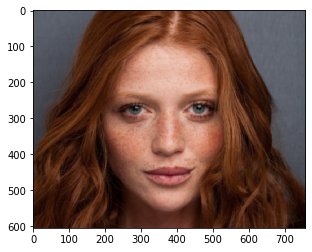

In [21]:
plt.imshow(blur.astype(int))

## 2. Binomial with seperable

In [22]:
#size is odd,n is even.
n=size-1
kernel=(1/(2**n))*np.asarray([ math.factorial(n)//math.factorial(k)//math.factorial(n-k) for k in range(n+1)],float).reshape((1,size))
tstart=time.time() #time start
blur_x=conv2D(image,kernel)
blur_xy=conv2D(blur_x,kernel.T)
tend=time.time() #time end
time_binomial_seperable=tend-tstart

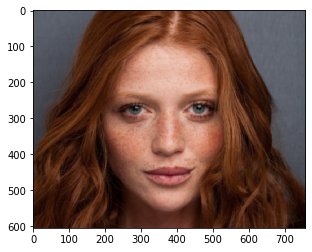

In [23]:
plt.imshow(blur_xy.astype(int))

## 3. opencv function
opencv library don't have binomial filter,so we use gaussian filter instead

In [24]:
tstart=time.time() #time start
blur=cv2.GaussianBlur(image,(size,size),0)
tend=time.time() #time end
time_cvgaussian=tend-tstart

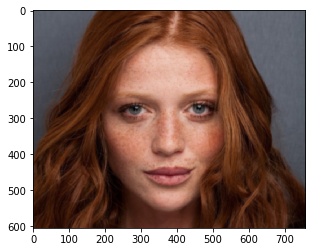

In [25]:
plt.imshow(blur.astype(int))

## 4. time consuming
By testing,7x7 filter takes almost the same time as 11x11 filter.  
But I don't known why 'Binomial with seperable' takes longer time than 'Binomial without seperable'...,maybe my conv2D method isn't optimized or parallelized.  
![so sad](https://media1.tenor.com/images/33327eabc5f7cc6f22e9005e6ccdefa9/tenor.gif?itemid=12721068)

In [26]:
print('1.without seperable: {:.2f} sec'.format(time_binomial))
print('2.with seperable: {:.2f} sec'.format(time_binomial_seperable))
print('3.opencv gaussian: {:.2f} sec'.format(time_cvgaussian))

1.without seperable: 8.42 sec
2.with seperable: 15.92 sec
3.opencv gaussian: 0.02 sec


# Bilateral Filter
1. implement bilateral fliter
2. how does sigma of closeness & sigma of similarity works
3. opencv function
4. compare two's computational time
5. compare bilateral filter with mean filter and binomial filter
6. fast bilateral filter

In [27]:
#7*7 or 11*11 size filter
size=7

## 1. implement bilateral filter
we need two weight matrix:  
1. __closeness weight matrix (euler distance)__
2. __similarity weight matix (intensity diffrence)__

both are similar to gaussian filter  
__result[i,j,c]=cross_correlation(image_section, normalized(closeness weight matrix .* similarity weight matrix))__

In [28]:
def closeness(H,W,sigma):
    r,c=np.mgrid[0:H:1,0:W:1]
    r-=H//2
    c-=W//2
    res=np.exp(-(np.power(r,2)+np.power(c,2))/(2*sigma*sigma))
    return res

In [29]:
def similarity(section,sigma):
    H,W=section.shape
    center_intensity=section[H//2,W//2]
    res=np.exp(-np.power(section-center_intensity,2)/(2*sigma*sigma))
    return res

Just like gaussian filter,we also need sigma for both weight matrix(or filter).

In [30]:
sigma_c=10  #sigma for closeness
sigma_s=0.1 #sigma for similarity

It's very important that we should __transform the image from range\[0,255\] to range\[0,1\]__ ,because of the similarity() function.Without tranformation,'section-center_intensity' in the np.power will return an extremely small similarity matix compared to the closeness matix.

In [31]:
tstart=time.time() #time start
closeness_filter=closeness(size,size,sigma_c)

image_pad=np.pad(image/255,((size//2,size//2),(size//2,size//2),(0,0)),'symmetric')
blur=np.zeros(image.shape,float)
H,W,C=blur.shape
for i in range(H):
    for j in range(W):
        for c in range(C):
            closeness_similarity_filter=closeness_filter*similarity(image_pad[i:i+size,j:j+size,c],sigma_s)
            #normalized
            closeness_similarity_filter=closeness_similarity_filter/np.sum(closeness_similarity_filter)
            blur[i,j,c]=cross_correlation(image_pad[i:i+size,j:j+size,c],closeness_similarity_filter)
tend=time.time() #time end
time_bilateral=tend-tstart

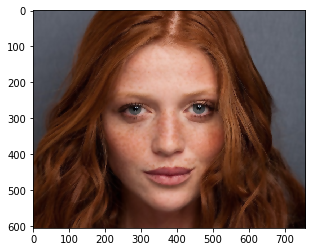

In [32]:
plt.imshow(blur) #because of image/255,so don't have to add .astype(int)

## 2. how sigma_closeness(distance) & sigma_similarity(intensity) works

we can find that:
* with the same sigma_closeness,the smaller sigma_similarity the more edge's detail we can see
* with the same sigma_similarity,the smaller sigma_closeness the more blurry effect we can see

In [33]:
def bilateral(sigma_c,sigma_s):
    closeness_filter=closeness(size,size,sigma_c)

    image_pad=np.pad(image/255,((size//2,size//2),(size//2,size//2),(0,0)),'symmetric')
    blur=np.zeros(image.shape,float)
    H,W,C=blur.shape
    for i in range(H):
        for j in range(W):
            for c in range(C):
                closeness_similarity_filter=closeness_filter*similarity(image_pad[i:i+size,j:j+size,c],sigma_s)
                #normalized
                closeness_similarity_filter=closeness_similarity_filter/np.sum(closeness_similarity_filter)
                blur[i,j,c]=cross_correlation(image_pad[i:i+size,j:j+size,c],closeness_similarity_filter)
    return blur

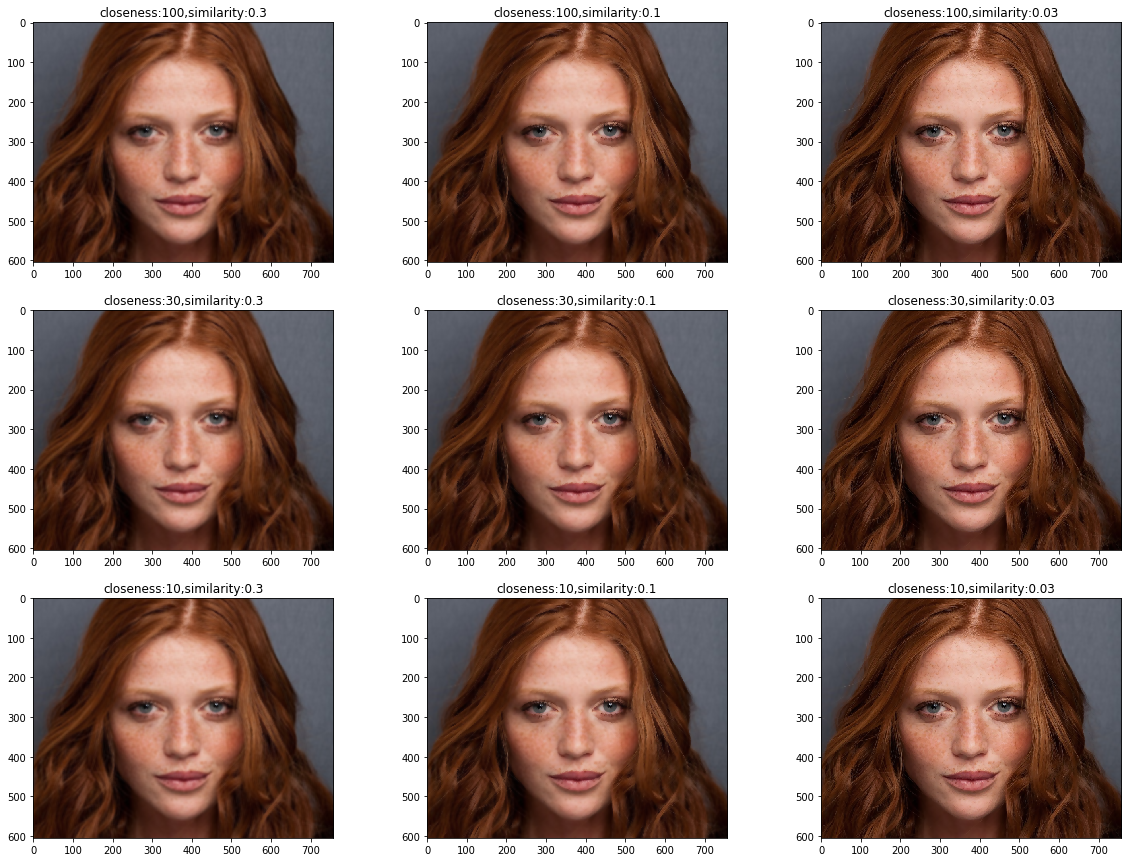

In [34]:
#watch out,this cell takes about 4 minutes to execute
sigma_c_list=[100,30,10] #big->small
sigma_s_list=[0.3,0.1,0.03] #big->small

plt.figure(figsize=(20,15))
i=1
for sigma_c in sigma_c_list:
    for sigma_s in sigma_s_list:
        plt.subplot(3,3,i)
        plt.imshow(bilateral(sigma_c,sigma_s))
        plt.title('closeness:{},similarity:{}'.format(sigma_c,sigma_s))
        i+=1

## 3. opencv function

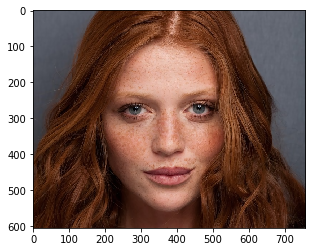

In [35]:
tstart=time.time() #time start
blur=cv2.bilateralFilter(image.astype('uint8'),size,9,9)
tend=time.time() #time end
time_cvbilateral=tend-tstart
plt.imshow(blur)

## 4. time consuming

In [36]:
print('1.bilateral: {:.2f} sec'.format(time_bilateral))
print('2.opencv bilateral: {:.2f} sec'.format(time_cvbilateral))

1.bilateral: 40.17 sec
2.opencv bilateral: 0.08 sec


## 5. compare with mean filter and binomial filter

retain edge attribute: mean<binomial<bilateral  
blurry effect: mean\>binomial\>bilateral  
computational time: mean<binomial<bilateral

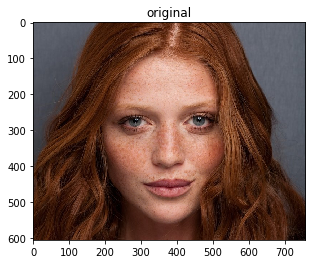

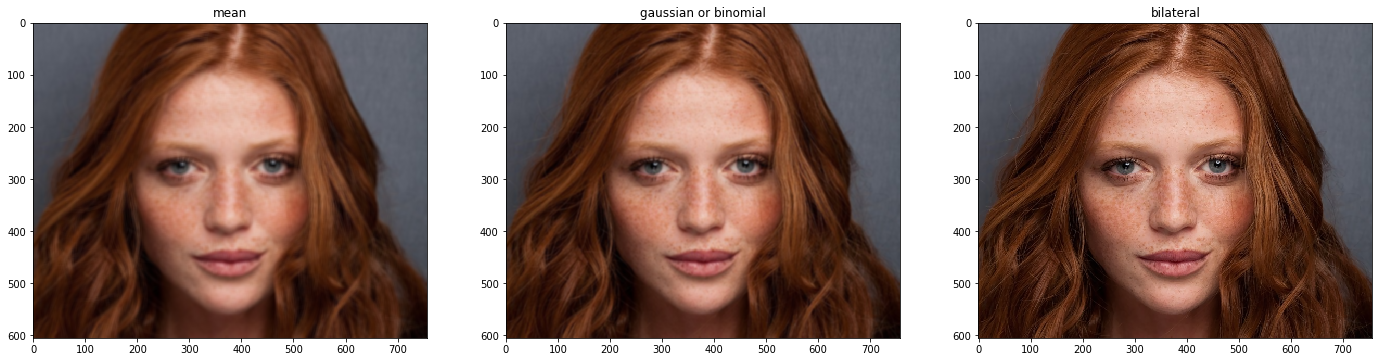

In [37]:
plt.imshow(image.astype(int))
plt.title('original')
plt.figure(figsize=(24,6))
plt.subplot(1,3,1)
res_mean=cv2.blur(image,(size,size))
plt.imshow(res_mean.astype(int))
plt.title('mean')
plt.subplot(1,3,2)
res_gaussian=cv2.GaussianBlur(image,(size,size),0)
plt.imshow(res_gaussian.astype(int))
plt.title('gaussian or binomial')
plt.subplot(1,3,3)
res_bilateral=cv2.bilateralFilter(image.astype('uint8'),size,9,9)
plt.imshow(res_bilateral)
plt.title('bilateral');

## 6. fast bilateral filter

[Fast Median and Bilateral Filtering](http://www.shellandslate.com/download/fastmedian_5506.pdf) by Ben Weiss  
_can't figure out..._  

# Scaling (zoomed in,out) 

How to get the pixel(i,j) value of the output image O? 

First,use affine matrix to get the pixel's posistion(x,y) of input image I  
Then,use interpolation to get the value of I(x,y)  

In [38]:
#zoom in/out t times
t=0.5

In [39]:
def interpolation(I,x,y,c):
    _x=math.floor(x)
    _y=math.floor(y)
    a=x-_x
    b=y-_y
    try:
        value=a*b*(I[_x,_y,c]+I[_x+1,_y+1,c]-I[_x+1,_y,c]-I[_x,_y+1,c])+a*(I[_x+1,_y,c]-I[_x,_y,c])+b*(I[_x,_y+1,c]-I[_x,_y,c])+I[_x,_y,c]
    except:
        value=0.
    return value

In [40]:
affine=np.array([[t,0,0],[0,t,0],[0,0,1]],float)
affine_inverse=np.linalg.inv(affine)
H,W,C=image.shape
H=math.floor(H*t)
W=math.floor(W*t)
Out=np.zeros((H,W,C),float)
for i in range(H):
    for j in range(W):
        for c in range(C):
            position=np.dot(affine_inverse,np.array([[i],[j],[1]],float))
            x=position[0,0]
            y=position[1,0]
            Out[i,j,c]=interpolation(image,x,y,c)

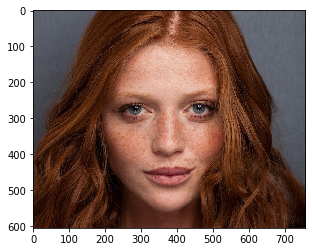

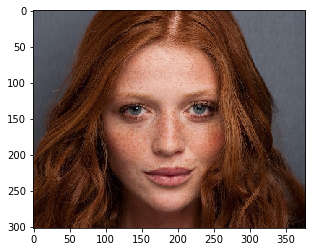

In [41]:
#input image
plt.imshow(image.astype(int))
#output image
plt.figure()
plt.imshow(Out.astype(int))